## DETR in `transformers`
In this notebook, we going through a simple example of using pretrained `detr-resnet-50` to detect some objects in an image.

In [1]:
%pip install timm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# this example is mainly from https://huggingface.co/facebook/detr-resnet-50

from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image, ImageDraw
import requests

C:\Users\alvin\miniconda3\envs\hf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

### Model
We are using `facebook/detr-resnet-50`, which is a basic DETR with a relatively small ResNet backbone. It has 100 object queries, which mean it can detect a maximum of 100 objects. 

In [4]:
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

### Processor
The processor converts the image into a dict with keys `pixel_values` and `pixel_mask`. The pixel values are usually transformed in a manner that matches the paper implementation, which may involve normalization, resizing, etc.

In [5]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
inputs = processor(images=image, return_tensors="pt")

C:\Users\alvin\miniconda3\envs\hf\lib\site-packages\transformers\models\detr\image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


### Outputs
The output of the model is of type `DetrObjectDetectionOutput`, which contains `logits`, `last_hidden_states`, `pred_boxes`, etc. <br>
The size of `logits` is `(batch size, n_object_queries, n_classes)`, which is used to determine the classes of the detections. This model has 100 object queries and 92 classes. The object queries that have low confidences in classes, or have a "no object" class are filtered out in the `post_process_object_detection` function. <br>
The size of `pred_boxes` is `(batch size, n_object_queries, box_dimensions)`, which is used to determine the location of the bounding box.

In [6]:
outputs = model(**inputs)

In [7]:
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]


In [9]:
img_draw = ImageDraw.Draw(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    img_draw.rectangle(((box[0], box[1]),(box[2], box[3])), outline='Red')
    img_draw.text((box[0], box[1]), model.config.id2label[label.item()], align ="left") 

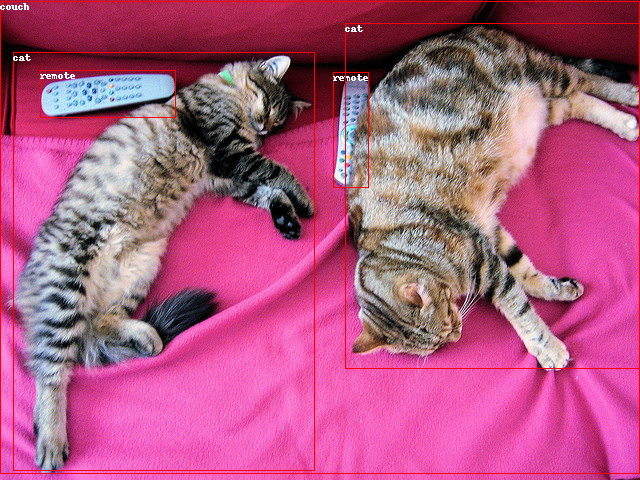

In [10]:
display(image)